## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №17

#### Часть 1
1. Из исходных изображений выделить похожие используя алгоритмы кластеризации. 
2. Обосновать какие метрики и алгоритмы лучше использовать для решения задачи.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, mixture
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import homogeneity_completeness_v_measure as hcv_score

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

X_ARRAY_FILE = 'Sign_lang_X.npy'
Y_ARRAY_FILE = 'Sign_lang_Y.npy'

### Загрузка, анализ и преобразование данных

Для работы выбран набор данных, содержащий изображения (64х64 пикселя) десятичных цифр от 0 до 9 с помошью языка жестов

Загрузка и формирование массивов данных

In [26]:
# Загрузить исходные изображения
X_src = np.load(X_ARRAY_FILE)

# Загрузить истинные метки классов
Y_src = np.load(Y_ARRAY_FILE)

# Преобразовать массив изобрежений в вектора
X = X_src.reshape(len(X_src), -1)
print(f'Массив векторов изображений: {X.shape}')

# Преобразовать изображения в черно-белое с порогом 0.5
#X = np.where(X < 0.5, 0, 1)  

# Получить массив меток
y = np.where(Y_src==1.)[1]
print(f'Массив меток классов: {y}')

Массив векторов изображений: (2062, 4096)
Массив меток классов: [0 0 0 ... 9 9 9]


Визуализация классов

<Figure size 640x480 with 0 Axes>

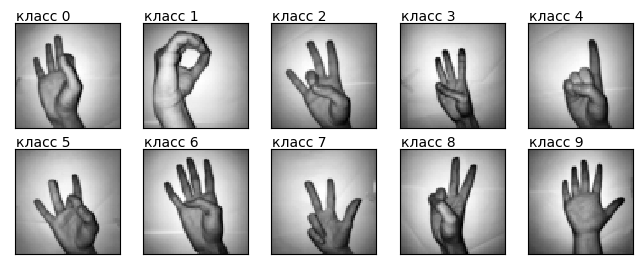

In [27]:
# Отобразить первые по порядку изображения каждого класса в сетке 3х4 
plt.gray()
fig = plt.figure(figsize=(8, 3))

for i in range(10):
    # Получить индекс первого изображения для заданного класса
    j = np.where(y == i)[0][0]
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X[j],[64,64]), interpolation='none')
    # Отобразить целевую метку класса для каждого изображения
    ax.text(0, -2, f'класс {y[j]}')

Визуальзация распределения средних значений пикселей по столбцам

In [28]:
'''
X_mean = np.mean(X_src, (2,0))

fig = plt.figure(figsize=(15, 3))
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.bar(*zip(*enumerate(X_mean,0)))
plt.show()
'''

"\nX_mean = np.mean(X_src, (2,0))\n\nfig = plt.figure(figsize=(15, 3))\nplt.minorticks_on()\nplt.grid(which='major')\nplt.grid(which='minor', linestyle=':')\nplt.bar(*zip(*enumerate(X_mean,0)))\nplt.show()\n"

Визуализацию сходства различных "символов" языка жестов с помошью алгоритма понижения размерности t-SNE

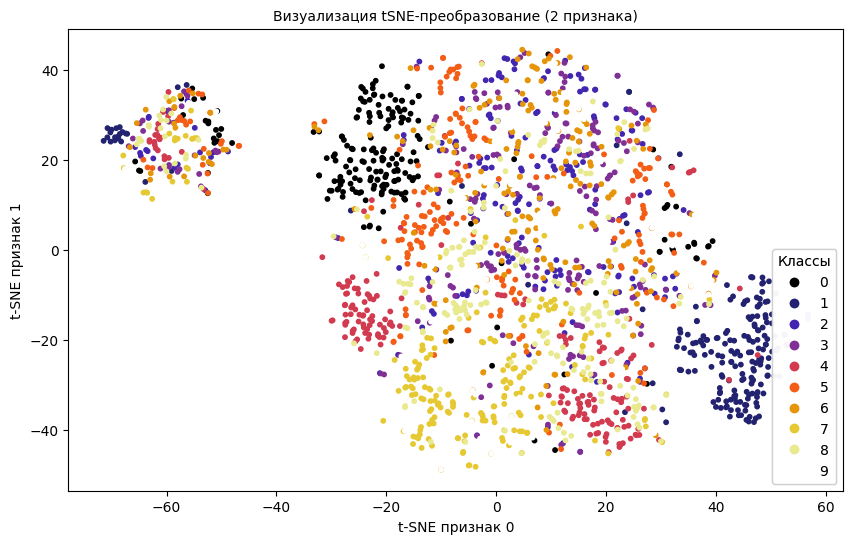

In [29]:
colors = ["#476A2A","#7851B8","#BD3430","#4A2D4E","#875525","#A83683","#4E655E","#853541","#3A3120","#535D8E"]
tsne = TSNE(learning_rate='auto', init='random', random_state=42)
X_tsne = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Визуализация tSNE-преобразование (2 признака)', fontsize=10)
plt.xlabel("t-SNE признак 0")
plt.ylabel("t-SNE признак 1")

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='CMRmap', s=10)
legend = ax.legend(*scatter.legend_elements(), loc='lower right', title='Классы')
ax.add_artist(legend)

plt.show()

#### Вывод:

- алгоритм t-SNE не смог выявить явных различий между классами изображений

### Кластеризация и оценка качества

Выполнить кластеризацию различными метдами и оценить метрики качества получившихся моделей для разного количества кластеров


In [30]:
scores = []
C = range(5,55,5)

for i in C:
    clusters = cluster.KMeans(n_clusters=i, n_init=100).fit_predict(X)
    a, hcv = adjusted_rand_score(y, clusters), hcv_score(y, clusters)
    scores.append(
        {
            'method': 'KMeans',
            'clusters': i,
            'accuracy': a,
            'homogeneity':hcv[0],
            'completeness':hcv[1],
            'v-measure':hcv[2],
        }
    )
    clusters = cluster.AgglomerativeClustering(n_clusters=i, linkage='ward').fit_predict(X)
    a, hcv = adjusted_rand_score(y, clusters), hcv_score(y, clusters)
    scores.append(
        {
            'method': 'Agglomerative',
            'clusters': i,
            'accuracy': a,
            'homogeneity':hcv[0],
            'completeness':hcv[1],
            'v-measure':hcv[2],
        }
    )
    clusters = cluster.Birch(n_clusters=i).fit_predict(X)
    a, hcv = adjusted_rand_score(y, clusters), hcv_score(y, clusters)
    scores.append(
        {
            'method': 'Birch',
            'clusters': i,
            'accuracy': a,
            'homogeneity':hcv[0],
            'completeness':hcv[1],
            'v-measure':hcv[2],
        }
    )

# Dataframe содержащий метрики для всех моделей всех алгоритмов кластеризации
df_scores = pd.DataFrame(scores)

Вмзуализировать метрики качества моделей

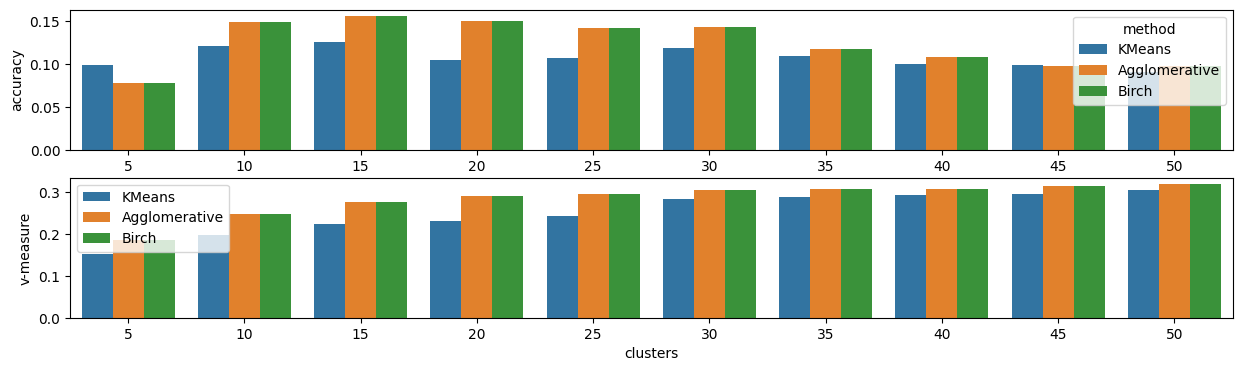

In [31]:
plt_num = 2
fig, axs = plt.subplots(ncols=1, nrows=plt_num, figsize=(15, 2*plt_num))
sns.barplot (data = df_scores, x = 'clusters', y = 'accuracy', hue='method', errorbar=None, ax=axs[0])
#sns.barplot (data = df_scores, x = 'clusters', y = 'homogeneity', hue='method', errorbar=None, ax=axs[1])
#sns.barplot (data = df_scores, x = 'clusters', y = 'completeness', hue='method', errorbar=None, ax=axs[2])
sns.barplot (data = df_scores, x = 'clusters', y = 'v-measure', hue='method', errorbar=None, ax=axs[1])
plt.legend()
plt.show()

#### Вывод:
- Алгоритмы Агломеративной кластеризации и Birch очень близки по точности и показывают лучшие значения метрик чем алгоритм K-средних
- Точность всех алгортмов на данном наборе данных очень низкая ~ 0.15

### Повышения точности моделей 
- Выполним преобразование изображений к монохромной форме
- Повторим проверку алгоритмов для количества кластеров = 10,15,20

In [32]:
# Преобразовать изображения в черно-белое с порогом 0.5
X = np.where(X < 0.5, 0, 1)

C = [10,15,20]
scores = []

for i in C:
    clusters = cluster.KMeans(n_clusters=i, n_init=100).fit_predict(X)
    a, hcv = adjusted_rand_score(y, clusters), hcv_score(y, clusters)
    scores.append(
        {
            'method': 'KMeans',
            'clusters': i,
            'accuracy': a,
            'homogeneity':hcv[0],
            'completeness':hcv[1],
            'v-measure':hcv[2],
        }
    )
    clusters = cluster.AgglomerativeClustering(n_clusters=i, linkage='ward').fit_predict(X)
    a, hcv = adjusted_rand_score(y, clusters), hcv_score(y, clusters)
    scores.append(
        {
            'method': 'Agglomerative',
            'clusters': i,
            'accuracy': a,
            'homogeneity':hcv[0],
            'completeness':hcv[1],
            'v-measure':hcv[2],
        }
    )
    clusters = cluster.Birch(n_clusters=i).fit_predict(X)
    a, hcv = adjusted_rand_score(y, clusters), hcv_score(y, clusters)
    scores.append(
        {
            'method': 'Birch',
            'clusters': i,
            'accuracy': a,
            'homogeneity':hcv[0],
            'completeness':hcv[1],
            'v-measure':hcv[2],
        }
    )

# Dataframe содержащий метрики для всех моделей всех алгоритмов кластеризации
df_scores = pd.DataFrame(scores)

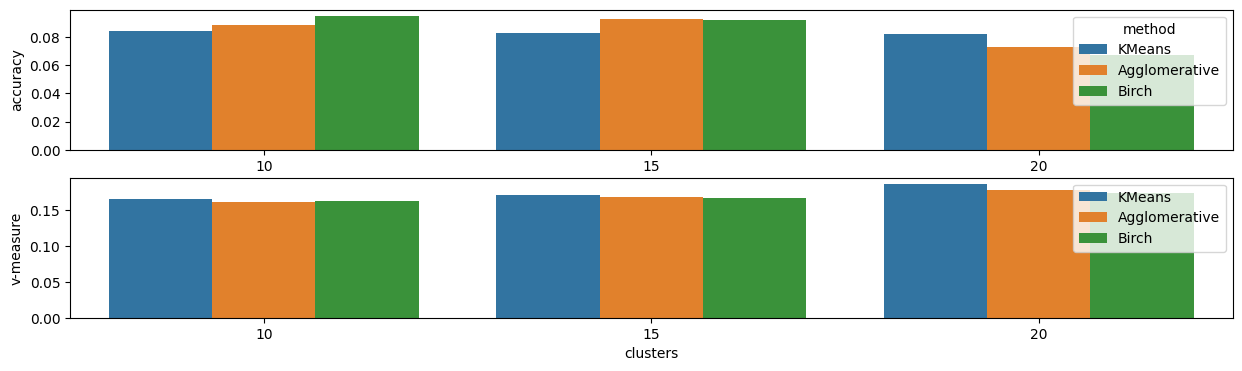

In [33]:
plt_num = 2
fig, axs = plt.subplots(ncols=1, nrows=plt_num, figsize=(15, 2*plt_num))
sns.barplot (data = df_scores, x = 'clusters', y = 'accuracy', hue='method', errorbar=None, ax=axs[0])
sns.barplot (data = df_scores, x = 'clusters', y = 'v-measure', hue='method', errorbar=None, ax=axs[1])
plt.legend()
plt.show()

#### Вывод:
- Точность всех алгоритмов на обработанном наборе данных существенно выросла с 0.15 до 0.8 !!!
- При этом разница между значениями метрик для разных алгоритмов практически исчезла
- Хотя остальные метрики моделей кроме точности ухудшились

Попробуем оптимизировать алгоритм Агломеративной кластеризации:

- Выполним перебор метаданных алгоритма для количества кластеров = 10

In [34]:
linkage = ['average','complete','single','ward']
affinity = ['cosine','euclidean','cityblock']
scores = []

for lnk,aff in [(l,a) for l in linkage for a in affinity]:

    # Ward can only work with euclidean distances
    if lnk == 'ward' and aff != 'euclidean': continue

    clusters = cluster.AgglomerativeClustering(n_clusters=i, linkage=lnk, affinity=aff).fit_predict(X)
    a, hcv = adjusted_rand_score(y, clusters), hcv_score(y, clusters)
    scores.append(
        {
            'params': f'{lnk}/{aff}',
            'accuracy': a,
            'homogeneity':hcv[0],
            'completeness':hcv[1],
            'v-measure':hcv[2],
        }
    )

# Dataframe содержащий метрики для всех построенных моделей алгоритма
df_ac_scores = pd.DataFrame(scores)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


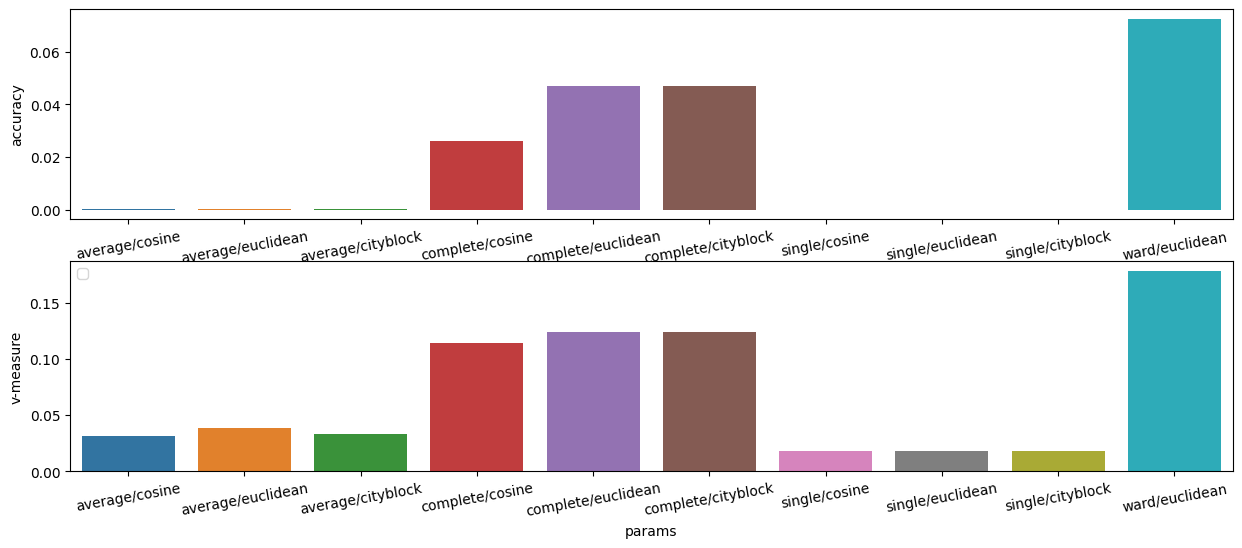

In [35]:
plt_num = 2
fig, axs = plt.subplots(ncols=1, nrows=plt_num, figsize=(15, 3*plt_num))

plot = sns.barplot (data = df_ac_scores, x = 'params', y = 'accuracy', errorbar=None, ax=axs[0])
plt.setp(plot.get_xticklabels(), rotation=10)
plot = sns.barplot (data = df_ac_scores, x = 'params', y = 'v-measure', errorbar=None, ax=axs[1])
plt.setp(plot.get_xticklabels(), rotation=10)
plt.legend()
plt.show()

#### Вывод:

- Метрики алгоритма имеют лучшие значения для модели с параметрами linkage = ward и affinity = euclidean (значения по умолчанию для алгоритма)

## Итого:
- Для оценки качества кластеризации использовались метрика точности adjusted_rand_score, а так же метрики однородности и полноты (homogeneity, completeness и v_measure)
- На необработанных данных (значения пикселей от 0 до 1 в градациях серого) алгоритмы Агломеративной кластеризации и Birch близки по значениям метрик и существенно превосходят алгоритм K-средних 
- На обработанных данных (перевод изображений в монохромную/бинарную форму) метрики всех алгоритмов близки по значениям, при этом метрика точности существенно улучшается, а метрики однородности и полноты ухудшаются
- Алгоритм Агломеративной кластеризации показывает лучшие результаты с параметрами по умолчанию (linkage = ward и affinity = euclidean).